## Statistische Modelle zur Verkaufspreisvorhersage

In [3]:
# Import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
import shap
import joblib
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb



In [4]:
# Daten einlesen
df = pd.read_parquet("cleaned_data.parquet")

In [5]:
df.head()

District  Nbhd                Style Extwall  Stories  Year_Built  \
0         7  2960                 AP 1   Frame      2.0        1913   
1         3  3170  Rm or Rooming House   Frame      2.0        1897   
2         4  3040  Rm or Rooming House   Frame      2.0        1907   
3         4  2300                 AP 1   Frame      2.0        1890   
4         4  2300              Mansion   Stone      2.5        1891   

   Nr_of_rms  Fin_sqft  Units  Bdrms  Fbath  Hbath  Lotsize  Sale_price  \
0          0      3476      4      9      1      0     5040       42000   
1          0      1992      4      2      2      0     2880      145000   
2          0      2339      6      0      1      0     3185       30000   
3          0      2329      4      4      1      0     5781       66500   
4          0      7450      2      7      6      0    15600      150500   

   year_sold  month_sold  
0       2002           2  
1       2002           5  
2       2002           6  
3       2002          10  
4       2002          11

In [6]:
df.dtypes

District        int64
Nbhd            int64
Style          object
Extwall        object
Stories       float64
Year_Built      int64
Nr_of_rms       int64
Fin_sqft        int64
Units           int64
Bdrms           int64
Fbath           int64
Hbath           int64
Lotsize         int64
Sale_price      int64
year_sold       int32
month_sold      int32
dtype: object

In [7]:
# konvertieren
df['District'] = df['District'].astype(object)
df['Nr_of_rms'] = df['Nr_of_rms'].astype(object)
df['Bdrms'] = df['Bdrms'].astype(object)
df['Fbath'] = df['Fbath'].astype(object)

In [8]:
df.dtypes


District       object
Nbhd            int64
Style          object
Extwall        object
Stories       float64
Year_Built      int64
Nr_of_rms      object
Fin_sqft        int64
Units           int64
Bdrms          object
Fbath          object
Hbath           int64
Lotsize         int64
Sale_price      int64
year_sold       int32
month_sold      int32
dtype: object

In [9]:
df_encoded = pd.get_dummies(df, columns=['District', 'Style', 'Extwall', 'Nr_of_rms', 'Bdrms', 'Fbath'])


In [10]:
df_encoded.head()

Nbhd  Stories  Year_Built  Fin_sqft  Units  Hbath  Lotsize  Sale_price  \
0  2960      2.0        1913      3476      4      0     5040       42000   
1  3170      2.0        1897      1992      4      0     2880      145000   
2  3040      2.0        1907      2339      6      0     3185       30000   
3  2300      2.0        1890      2329      4      0     5781       66500   
4  2300      2.5        1891      7450      2      0    15600      150500   

   year_sold  month_sold  ...  Fbath_0  Fbath_1  Fbath_2  Fbath_3  Fbath_4  \
0       2002           2  ...    False     True    False    False    False   
1       2002           5  ...    False    False     True    False    False   
2       2002           6  ...    False     True    False    False    False   
3       2002          10  ...    False     True    False    False    False   
4       2002          11  ...    False    False    False    False    False   

   Fbath_5  Fbath_6  Fbath_7  Fbath_8  Fbath_10  
0    False    False    False    False     False  
1    False    False    False    False     False  
2    False    False    False    False     False  
3    False    False    False    False     False  
4    False     True    False    False     False  

[5 rows x 158 columns]

## Modelle
Die folgenden Modell wurden ebenfalls mit den num_features = ['Stories', 'Nr_of_rms', 'Fin_sqft', 'Bdrms', 'Fbath', 'Lotsize', 'year_sold', 'month_sold'] trainiert. Jedoch waren die Wahrscheinlichkeiten deutlich schlechter, deshalb wurden mehr Variablen eingebunden und im weiteren Verlauf verwendet


In [11]:
y = "Sale_price"
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 

# Überprüfen, ob alle Features und die Zielvariable in den Daten vorhanden sind
print("Spalten in den Daten:", df.columns)
print("Vorhandene Features:", [feature for feature in num_features if feature in df.columns])
print("Vorhandene Zielvariable:", y in df.columns)

Spalten in den Daten: Index(['District', 'Nbhd', 'Style', 'Extwall', 'Stories', 'Year_Built',
       'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize',
       'Sale_price', 'year_sold', 'month_sold'],
      dtype='object')
Vorhandene Features: ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold']
Vorhandene Zielvariable: True


In [12]:
X = df[num_features]
y = df[y]

In [13]:
train_data, test_data = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

### Modell 1: Lineare Regression

In [14]:
# Zielvariable und Features
y = "Sale_price"
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 

# Erstellen des ColumnTransformer
ct_1 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)  # Standardisierung der numerischen Features
    ],
)

# Erstellen der Pipeline
pipeline_1 = Pipeline(steps=[
    ("ct1", ct_1),                     # Vorverarbeitung der Daten
    ("model_linreg", LinearRegression())  # Modell für die lineare Regression
])


In [15]:
pipeline_1.fit(X=train_data[num_features], y=train_data[y])

Pipeline(steps=[('ct1',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Stories', 'Year_Built',
                                                   'Nr_of_rms', 'Fin_sqft',
                                                   'Units', 'Bdrms', 'Fbath',
                                                   'Hbath', 'Lotsize',
                                                   'year_sold',
                                                   'month_sold'])])),
                ('model_linreg', LinearRegression())])

In [16]:
# Trainieren und Evaluieren des Modells
scores = cross_val_score(estimator=pipeline_1, X=train_data[num_features], y=train_data[y], cv=5)

# Ausgabe der Kreuzvalidierungsergebnisse
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Cross-Validation Score: {scores.mean()}")

Cross-Validation Scores: [0.31876901 0.34609803 0.30065921 0.3316153  0.32503623]
Mean Cross-Validation Score: 0.3244355544494134


In [17]:
# Trainieren der Pipeline auf den gesamten Trainingsdaten
pipeline_1.fit(train_data[num_features], train_data[y])

# Evaluierung des Modells auf dem Testdatensatz
test_score_1 = pipeline_1.score(test_data[num_features], test_data[y])
print(f"Test Score (R^2): {test_score_1}")

# Vorhersagen treffen
y_pred = pipeline_1.predict(test_data[num_features])
mse = mean_squared_error(test_data[y], y_pred)
print(f"Mean Squared Error: {mse}")

Test Score (R^2): 0.3403221045993402
Mean Squared Error: 647364956223.6688


### Modell 2: Decision Tree Regressor

In [18]:

# Zielvariable und Features
y = "Sale_price"
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 


In [19]:
# Daten in Trainings- und Testdaten aufteilen
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Erstellen des ColumnTransformer
ct_2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)  
    ],
)


In [20]:

# Erstellen der Pipeline
pipeline_2 = Pipeline(steps=[
    ("ct2", ct_2),                     
    ("model_dtr", DecisionTreeRegressor(random_state=42)) 
])


In [21]:

# Kreuzvalidierung
scores = cross_val_score(estimator=pipeline_1, X=train_data[num_features], y=train_data[y], cv=5)

# Ausgabe der Kreuzvalidierungsergebnisse
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Cross-Validation Score: {scores.mean()}")


Cross-Validation Scores: [0.31876901 0.34609803 0.30065921 0.3316153  0.32503623]
Mean Cross-Validation Score: 0.3244355544494134


In [22]:

# Trainieren der Pipeline auf den gesamten Trainingsdaten
pipeline_2.fit(train_data[num_features], train_data[y])


Pipeline(steps=[('ct2',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Stories', 'Year_Built',
                                                   'Nr_of_rms', 'Fin_sqft',
                                                   'Units', 'Bdrms', 'Fbath',
                                                   'Hbath', 'Lotsize',
                                                   'year_sold',
                                                   'month_sold'])])),
                ('model_dtr', DecisionTreeRegressor(random_state=42))])

In [23]:

# Evaluierung des Modells auf dem Testdatensatz
test_score_2 = pipeline_2.score(test_data[num_features], test_data[y])
print(f"Test Score (R^2): {test_score_2}")

# Vorhersagen auf dem Testdatensatz treffen
y_pred = pipeline_2.predict(test_data[num_features])
mse = mean_squared_error(test_data[y], y_pred)
print(f"Mean Squared Error: {mse}")


Test Score (R^2): 0.6497759896060489
Mean Squared Error: 343687052026.28674


## Modell 3: Decison Tree inkl. Simple Imputer

In [24]:
# Zielvariable und Features
y = "Sale_price"
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 

In [25]:
# Daten in Trainings- und Testdaten aufteilen
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [26]:

# Erstellen des ColumnTransformers für Imputation und Skalierung der numerischen Features
ct_3 = ColumnTransformer(
    transformers=[
        ("imp_scale", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features)
    ],
)


In [27]:

# Erstellen des Entscheidungsbaum-Modells
est_3 = DecisionTreeRegressor(max_depth=7, min_samples_split=200, random_state=42)

# Erstellen der Pipeline
pipeline_3 = Pipeline(steps=[("prep", ct_3), ("model", est_3)])

# Kreuzvalidierung
cross_val_scores = cross_val_score(estimator=pipeline_3, X=train_data[num_features], y=train_data[y], cv=5)


In [28]:

# Ausgabe der Kreuzvalidierungsergebnisse
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean()}")


Cross-Validation Scores: [0.75329428 0.79197527 0.73398763 0.74295097 0.76701237]
Mean Cross-Validation Score: 0.7578441057538887


In [29]:

# Trainieren der Pipeline auf den gesamten Trainingsdaten
pipeline_3.fit(train_data[num_features], train_data[y])


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('imp_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Stories', 'Year_Built',
                                                   'Nr_of_rms', 'Fin_sqft',
                                                   'Units', 'Bdrms', 'Fbath',
                                                   'Hbath', 'Lotsize',
                                                   'year_sold',
                                                   'month_sold'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=7, min_samples_split=200,
                                       random_state=42))])

In [30]:

# Evaluierung des Modells auf dem Testdatensatz
test_score_3 = pipeline_3.score(test_data[num_features], test_data[y])
print(f"Test Score (R^2): {test_score_3}")

# Vorhersagen treffen
y_pred = pipeline_3.predict(test_data[num_features])
mse = mean_squared_error(test_data[y], y_pred)
print(f"Mean Squared Error: {mse}")


Test Score (R^2): 0.7636057684944944
Mean Squared Error: 231981914805.77603


## Modell 4: Light Gradient Boosting

In [31]:
# Zielvariable und Features
y = "Sale_price"
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 


In [32]:

# Daten in Trainings- und Testdaten aufteilen
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [33]:

# Erstellen des ColumnTransformers für Imputation und Skalierung der numerischen Features
ct_4 = ColumnTransformer(
    transformers=[
        ("imp_scale", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features)
    ],
)

# Erstellen des LightGBM-Regressors
est_4 = LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42)
# hier wurden verschiedene Werte ausprobiert, diese Kombination war die beste 



In [34]:

# Erstellen der Pipeline
pipeline_4 = Pipeline(steps=[("prep", ct_4), ("model", est_4)])


In [35]:

# Kreuzvalidierung
cross_val_scores = cross_val_score(estimator=pipeline_4, X=train_data[num_features], y=train_data[y], cv=5)

# Ausgabe der Kreuzvalidierungsergebnisse
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean()}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 29860, number of used features: 11
[LightGBM] [Info] Start training from score 608800.168486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [36]:

# Trainieren der Pipeline auf den gesamten Trainingsdaten
pipeline_4.fit(train_data[num_features], train_data[y])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 37326, number of used features: 11
[LightGBM] [Info] Start training from score 608683.490489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('imp_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Stories', 'Year_Built',
                                                   'Nr_of_rms', 'Fin_sqft',
                                                   'Units', 'Bdrms', 'Fbath',
                                                   'Hbath', 'Lotsize',
                                                   'year_sold',
                                                   'month_sold'])])),
                ('model', LGBMRegressor(max_depth=7, random_state=42))])

In [37]:

# Evaluierung des Modells auf dem Testdatensatz
test_score_4 = pipeline_4.score(test_data[num_features], test_data[y])
print(f"Test Score (R^2): {test_score_4}")

# Vorhersagen auf dem Testdatensatz treffen
y_pred = pipeline_4.predict(test_data[num_features])
mse = mean_squared_error(test_data[y], y_pred)
print(f"Mean Squared Error: {mse}")


Test Score (R^2): 0.8112904535878742
Mean Squared Error: 185187268064.9351


## Was hat das Modell gelernt?

In [38]:
feature_names = num_features

In [39]:
transformed_test_4 = pipeline_4[:-1].transform(X=test_data[num_features])

In [40]:
transformed_test_4.shape


(9332, 11)

In [41]:
explainer_4 = shap.TreeExplainer(model=est_4)

In [42]:
shap_values_test_4 = explainer_4.shap_values(X=transformed_test_4)

In [43]:
explainer_4.expected_value

608683.4904903163

In [44]:
train_data["Sale_price"].mean()

608683.4904892033

In [45]:
explanation_4 = explainer_4(X=transformed_test_4)
explanation_4.feature_names = feature_names

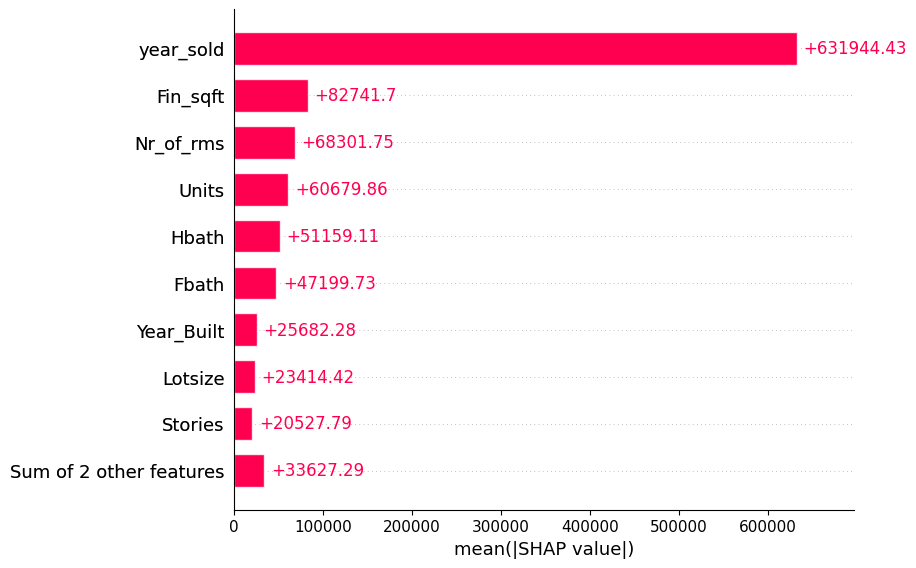

In [46]:
shap.plots.bar(shap_values=explanation_4)

## Hyperparameteroptimierung

In [48]:
# Dauert zwischen 8-10 Min.
# Parametergrid für GridSearch
parameters = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [5, 7, 9],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__subsample": [0.7, 0.8, 0.9]
}

# GridSearchCV initialisieren
search = GridSearchCV(estimator=pipeline_4, param_grid=parameters, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fitting der GridSearchCV
search.fit(train_data[num_features], train_data[y])

# Beste Parameter und Score anzeigen
print("Beste Parameter:", search.best_params_)
print("Bester Score (neg_mean_squared_error):", search.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 29861, number of used features: 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 29860, number of used features: 11
[LightGBM] [Info] Number of data points in the train set: 29861, number of used features: 11
[LightGBM] [Info] Start training from score 609033.479689[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testi

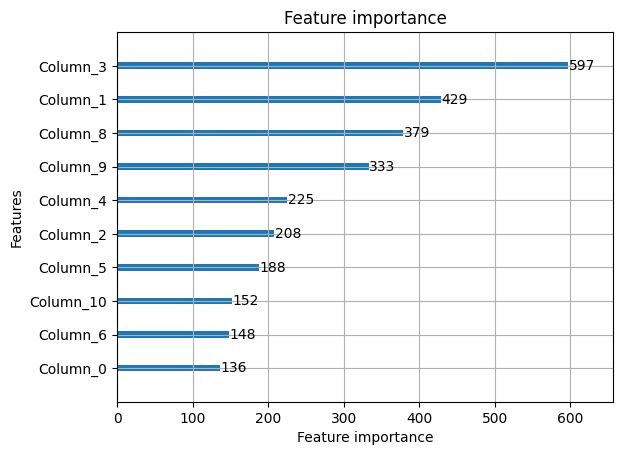

In [49]:
import matplotlib.pyplot as plt
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 


# Bestes Modell aus GridSearch
best_model = search.best_estimator_.named_steps['model']
feature_names = num_features 

# Feature-Wichtigkeit berechnen und plotten
lgb.plot_importance(best_model.booster_, importance_type='split', max_num_features=10)
plt.show()


In [50]:

# Beste Parameter und Score anzeigen
print("Beste Parameter:", search.best_params_)
print("Bester Score (neg_mean_squared_error):", search.best_score_)

# Evaluierung des besten Modells auf dem Testdatensatz
best_model = search.best_estimator_
test_score = best_model.score(test_data[num_features], test_data[y])
print(f"Test Score (R^2): {test_score}")

# Vorhersagen auf dem Testdatensatz treffen
y_pred = best_model.predict(test_data[num_features])
mse = mean_squared_error(test_data[y], y_pred)
print(f"Mean Squared Error: {mse}")


Beste Parameter: {'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 100, 'model__subsample': 0.7}
Bester Score (neg_mean_squared_error): -184755008906.56647
Test Score (R^2): 0.8114470590891247
Mean Squared Error: 185033585617.53415


## Modell 5: Optimiertes Light Gradient Boosting

In [51]:
# Zielvariable und Features
y = "Sale_price"
num_features = ['Stories', 'Year_Built', 'Nr_of_rms', 'Fin_sqft', 'Units', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'year_sold', 'month_sold'] 

In [52]:

# Daten in Trainings- und Testdaten aufteilen
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [53]:

# Erstellen des ColumnTransformers für Imputation und Skalierung der numerischen Features
ct_5 = ColumnTransformer(
    transformers=[
        ("imp_scale", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features)
    ],
)

# Erstellen des LightGBM-Regressors
est_5 = LGBMRegressor(n_estimators=100, max_depth=9, learning_rate=0.1, random_state=42)

In [54]:

# Erstellen der Pipeline
pipeline_5 = Pipeline(steps=[("prep", ct_5), ("model", est_5)])

In [55]:

# Kreuzvalidierung
cross_val_scores = cross_val_score(estimator=pipeline_5, X=train_data[num_features], y=train_data[y], cv=5)

# Ausgabe der Kreuzvalidierungsergebnisse
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean()}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 29860, number of used features: 11
[LightGBM] [Info] Start training from score 608800.168486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [56]:

# Trainieren der Pipeline auf den gesamten Trainingsdaten
pipeline_5.fit(train_data[num_features], train_data[y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 793
[LightGBM] [Info] Number of data points in the train set: 37326, number of used features: 11
[LightGBM] [Info] Start training from score 608683.490489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('imp_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Stories', 'Year_Built',
                                                   'Nr_of_rms', 'Fin_sqft',
                                                   'Units', 'Bdrms', 'Fbath',
                                                   'Hbath', 'Lotsize',
                                                   'year_sold',
                                                   'month_sold'])])),
                ('model', LGBMRegressor(max_depth=9, random_state=42))])

In [57]:

# Evaluierung des Modells auf dem Testdatensatz
test_score_5 = pipeline_5.score(test_data[num_features], test_data[y])
print(f"Test Score (R^2): {test_score_5}")

# Vorhersagen auf dem Testdatensatz treffen
y_pred = pipeline_5.predict(test_data[num_features])
mse = mean_squared_error(test_data[y], y_pred)
print(f"Mean Squared Error: {mse}")

Test Score (R^2): 0.8114470590891247
Mean Squared Error: 185033585617.53415


In [58]:
# Speichern des besten Modells für die folgende Vorhersage
joblib.dump(pipeline_5, 'Bestmodel.pkl')

['BestModel.pkl']

## Was hat das Modell gelernt?

In [59]:
feature_names = num_features

In [60]:
transformed_test_5 = pipeline_5[:-1].transform(X=test_data[num_features])

In [61]:
transformed_test_5.shape


(9332, 11)

In [62]:
explainer_5 = shap.TreeExplainer(model=est_5)

In [63]:
shap_values_test_5 = explainer_5.shap_values(X=transformed_test_5)

In [64]:
explainer_5.expected_value

608683.490473785

In [65]:
train_data["Sale_price"].mean()

608683.4904892033

In [66]:
explanation_5 = explainer_5(X=transformed_test_5)
explanation_5.feature_names = feature_names

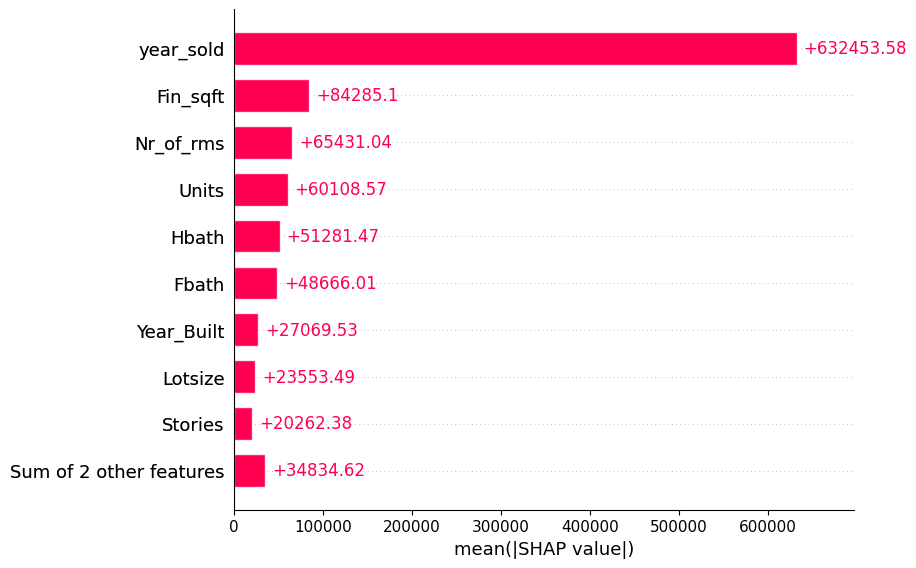

In [67]:
shap.plots.bar(shap_values=explanation_5)

## Modell Vergleich

In [68]:
test_scores = [test_score_1, test_score_2, test_score_3, test_score_4, test_score_5]

# Dataframe aller Scores
score_df = pd.DataFrame({
    "Pipeline": ["Pipeline_1 - Lineare Regression", "Pipeline_2 - Decision Tree Regressor", "Pipeline_3 - Decision Tree inkl. SI", "Pipeline_4 - Light Gradient Boosting", "Pipeline_5 - Optimiertes LGB"],
    "Test Score (R^2)": test_scores
})

print(score_df)

                               Pipeline  Test Score (R^2)
0       Pipeline_1 - Lineare Regression          0.340322
1  Pipeline_2 - Decision Tree Regressor          0.649776
2   Pipeline_3 - Decision Tree inkl. SI          0.763606
3  Pipeline_4 - Light Gradient Boosting          0.811290
4          Pipeline_5 - Optimiertes LGB          0.811447
